# Transformer Encoder with Mixed (Legendre + B-Spline) embeddings
Here we demonstrate we can use curves as input embeddings to a Transformer model that learns from tabular data. The
categorical features are treated as regular tokens having embedding vectors. Numerical feature embeddings are points
on curves defined by B-Splines and Legendre polynomials. We also show that it might be reasonable to use B-Splines
do define features of "spatial" nature, such as latitude and longitude, whereas use Legendre curves for features
of "spectral" nature - there is some overall trend of the target variable behavior as a function of the feature that
can be captured by the lower frequency components.

In [1]:
import kagglehub as kh
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as td
from torch import nn
import torchcurves as tc
from typing import Sequence
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

## Prepare data

In [2]:
file_path = "housing.csv"
df = kh.dataset_load(
    kh.KaggleDatasetAdapter.PANDAS,
    "camnugent/california-housing-prices",
    file_path
)

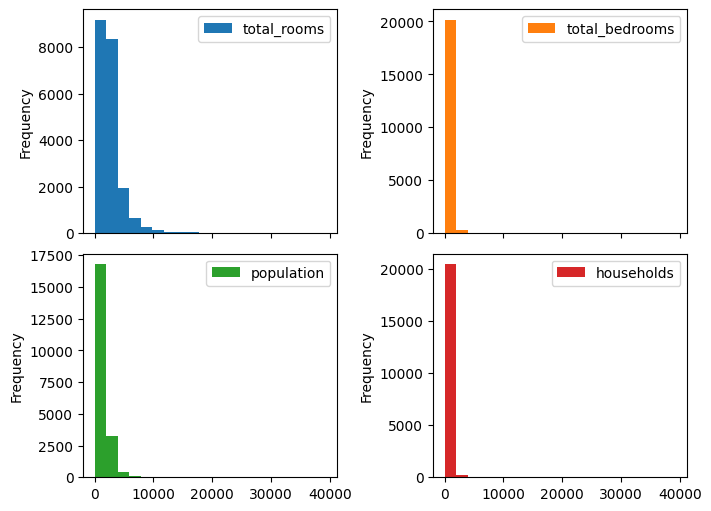

In [3]:
# columns that we know have a very skewed distribution
skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
df[skewed_columns].plot.hist(
    bins=20, subplots=True, layout=(2, 2), figsize=(7, 5)
)
plt.gcf().set_layout_engine('constrained')

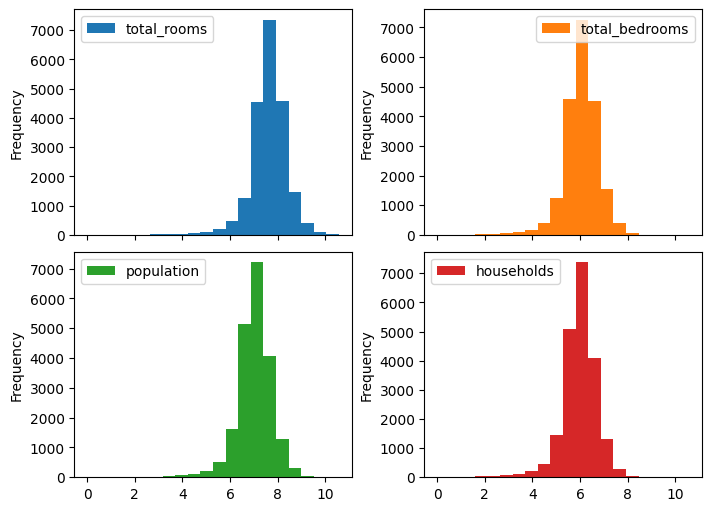

In [4]:
# apply log transformation and plot histograms
df.loc[:, skewed_columns] = df[skewed_columns].apply(np.log)
df[skewed_columns].plot.hist(
    bins=20, subplots=True, layout=(2, 2), figsize=(7, 5)
)
plt.gcf().set_layout_engine('constrained')

In [5]:
spectral_cols = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
spatial_cols = ['longitude', 'latitude', 'housing_median_age']
numerical_cols = spectral_cols + spatial_cols
cat_cols = ['ocean_proximity']
label_col = 'median_house_value'

In [6]:
train_df = df.sample(frac=0.8, random_state=2025)
test_df = df.drop(train_df.index)

## Preprocess data

In [7]:
X_train, y_train = train_df.drop(label_col, axis=1), train_df[[label_col]]
X_test, y_test = test_df.drop(label_col, axis=1), test_df[[label_col]]

In [8]:
feat_preprocessor = make_column_transformer(
    (OrdinalEncoder(), cat_cols), # categorical: ordinal encode
    (make_pipeline(
        SimpleImputer(),
        StandardScaler()
    ), spectral_cols),            # spectral: impute then standardize
    (make_pipeline(
        SimpleImputer(),
        MinMaxScaler(feature_range=(-1, 1), clip=True)
    ), spatial_cols),            # spatial: impute then minmax-scale
    verbose_feature_names_out=False
).set_output(transform='pandas')
label_preprocessor = StandardScaler()

In [9]:
X_train_pp = feat_preprocessor.fit_transform(X_train)
X_test_pp = feat_preprocessor.transform(X_test)

y_train_pp = label_preprocessor.fit_transform(y_train)
y_test_pp = label_preprocessor.transform(y_test)

In [10]:
X_train_pp[cat_cols] = X_train_pp[cat_cols].astype(np.int32)
X_train_pp[numerical_cols] = X_train_pp[numerical_cols].astype(np.float32)
X_test_pp[cat_cols] = X_test_pp[cat_cols].astype(np.int32)
X_test_pp[numerical_cols] = X_test_pp[numerical_cols].astype(np.float32)

col_sets = [spectral_cols, spatial_cols, cat_cols]
X_train_tensors = tuple(torch.as_tensor(X_train_pp[cols].values) for cols in col_sets)
X_test_tensors = tuple(torch.as_tensor(X_test_pp[cols].values) for cols in col_sets)

In [11]:
num_cat_features = [
    len(cats) for cats in feat_preprocessor['ordinalencoder'].categories_
]

In [12]:
len(X_train)

16512

## Evaluate baselines

In [13]:
baseline_model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), cat_cols),
        remainder='passthrough'
    ),
    HistGradientBoostingRegressor(loss='squared_error')
)
baseline_model.fit(X_train, y_train.values.ravel())
pred = baseline_model.predict(X_test)
baseline_rmse = root_mean_squared_error(y_test, pred)
print(f'Baseline RMSE = {baseline_rmse}')

Baseline RMSE = 47452.289770557385


In [14]:
baseline_model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(), cat_cols),  # categorical: one-hot encode
        (make_pipeline(
            SimpleImputer(),
            StandardScaler(),
        ), spectral_cols),            # spectral: impute then standardize
        (make_pipeline(
            SimpleImputer(),
            MinMaxScaler(feature_range=(-1, 1), clip=True)
        ), spatial_cols),            # spatial: impute then minmax-scale
    ),
    LinearRegression()
)
baseline_model.fit(X_train, y_train.values.ravel())
pred = baseline_model.predict(X_test)
baseline_rmse = root_mean_squared_error(y_test, pred)
print(f'Baseline RMSE = {baseline_rmse}')

Baseline RMSE = 65307.28156452822


## Train and evaluate transformers

### Define modules

In [15]:
class EmbeddingLayer(nn.Module):
    def __init__(self, n_spectral: int, n_spatial: int, n_cat: Sequence[int], emb_dim: int, n_coef: int = 10,
                 dropout_p=0.1):
        super().__init__()

        # offset for the categorical feature of each column
        offsets = [sum(n_cat[:i]) for i in range(len(n_cat))]
        self.register_buffer("offsets", torch.tensor(offsets))

        # embeddings for each type of feature
        self.spectral_emb = tc.LegendreCurve(n_spectral, emb_dim, degree=n_coef - 1, normalize_fn='rational')
        self.spatial_emb = tc.BSplineEmbeddings(n_spatial, emb_dim, knots_config=n_coef, normalize_fn='clamp')
        self.cat_emb = nn.Embedding(sum(n_cat), emb_dim)

        # post-processing for the embeddings, before feeding them into the transformer
        self.postprocess = nn.Sequential(nn.LayerNorm(emb_dim), nn.Dropout(dropout_p))

    def forward(self, x_spectral, x_spatial, x_cat):
        spectral_emb = self.spectral_emb(x_spectral)
        spatial_emb = self.spatial_emb(x_spatial)
        cat_emb = self.cat_emb(x_cat + self.offsets.to(x_cat.dtype).unsqueeze(0))
        emb = torch.concatenate((spectral_emb, spatial_emb, cat_emb), dim=-2)
        return self.postprocess(emb)

    @staticmethod
    def get_offsets(n_cat: Sequence[int]):
        sum = 0
        yield sum
        for n in n_cat:
            sum += n

In [16]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_len=16, base=16.0):
        super().__init__()
        h = emb_dim // 2
        pos = torch.arange(max_len)[:, None]
        div = base ** (2 * torch.arange(h) / emb_dim)
        ang = pos / div
        pe = torch.empty(max_len, emb_dim)
        pe[:, 0::2] = ang.sin()
        pe[:, 1::2] = ang.cos()
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0).type_as(x)

In [17]:
class TransformerModel(nn.Module):
    def __init__(self,
                 n_spectral: int, n_spatial: int, n_cat: Sequence[int], emb_dim: int, n_coef: int = 10,
                 num_heads: int = 4, num_layers: int = 4, dim_feedforward: int | None = None):
        dim_feedforward = dim_feedforward if dim_feedforward is not None else 4 * emb_dim
        super().__init__()
        self.embeddings = EmbeddingLayer(n_spectral, n_spatial, n_cat, emb_dim, n_coef)
        self.pe = SinusoidalPositionalEncoding(emb_dim, max_len=n_spectral + n_spatial + len(n_cat))
        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                emb_dim, num_heads, batch_first=True, dim_feedforward=dim_feedforward
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(emb_dim, 1)

    def forward(self, tensors: Sequence[torch.Tensor]):
        emb = self.embeddings(*tensors)
        pos_emb = self.pe(emb)
        encoded = self.transformer(pos_emb)
        pooled = torch.mean(encoded, axis=-2)
        return self.fc(pooled)

### Define config

In [ ]:
# architecture
n_curve_coefs = 16
num_layers = 4
emb_dim = 32
num_heads = 4

# training loop params
num_epochs = 100
print_every = 10
batch_size = 32

# optimizer params - common heuristics for transformers
optimizer_params = dict(
    lr = 0.001,
    weight_decay = 0.1,
    betas = (0.9, 0.95)
)

# sizes
num_features = X_train_pp.shape[1]
train_set_size = len(X_train_pp)
test_set_size = len(X_test_pp)

In [26]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Define training loop

In [27]:
train_ds = td.TensorDataset(*X_train_tensors, torch.as_tensor(y_train_pp).float())
eval_ds = td.TensorDataset(*X_test_tensors, torch.as_tensor(y_test_pp).float())

In [28]:
def train_epoch(model, optim, lr_scheduler, criterion, train_dl):
    tr_loss = torch.tensor(0.).to(device)
    for *Xb, yb in train_dl:
        pred = model(xb.to(device) for xb in Xb)
        loss = criterion(yb.to(device), pred)

        optim.zero_grad()
        loss.backward()
        optim.step()
        lr_scheduler.step()

        with torch.no_grad():
            tr_loss += loss * torch.numel(yb)
    return tr_loss.item() / train_set_size


@torch.no_grad
def eval_epoch(model, eval_criterion, eval_dl):
    eval_total_error = 0.
    for *Xb, yb in eval_dl:
        # predict
        pred = model(xb.to(device) for xb in Xb)

        # compute label and prediction in terms of the original, unscaled labels
        label_orig = label_preprocessor.inverse_transform(yb.view(-1, 1))
        pred_orig = label_preprocessor.inverse_transform(pred.cpu().view(-1, 1))

        # compute loss on the original labels
        loss = eval_criterion(
            torch.as_tensor(label_orig, device=device, dtype=torch.float32),
            torch.as_tensor(pred_orig, device=device, dtype=torch.float32)
        )
        eval_total_error += loss * torch.numel(yb)
    return eval_total_error.item() / test_set_size

In [29]:
def get_linear_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0., 1.0 - progress)

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

In [30]:
def train_eval_model(name, model: nn.Module, batch_size: int, print_progress=True, **optim_kwargs):
    model = model.to(device)
    optim = torch.optim.AdamW(model.parameters(), **optim_kwargs)
    criterion = nn.MSELoss()
    train_dl = td.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    eval_dl = td.DataLoader(eval_ds, batch_size=128)

    total_steps = len(train_dl) * num_epochs
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_scheduler(optim, warmup_steps, total_steps)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, optim, scheduler, criterion, train_dl)

        if print_progress and (epoch % print_every == 0 or epoch == num_epochs):
            model.eval()
            eval_loss = eval_epoch(model, criterion, eval_dl)
            eval_rmse = math.sqrt(eval_loss)
            model.train()

            print(f'[{name}] Epoch {epoch}, tr loss = {train_loss:.4f}, eval RMSE = {eval_rmse:.2f}')

    return model

### Run experiments

In [31]:
model = train_eval_model(
    "Transformer",
    TransformerModel(
        len(spectral_cols), len(spatial_cols), num_cat_features,
        emb_dim=emb_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        n_coef=n_curve_coefs,
    ),
    batch_size=batch_size,
    **optimizer_params,
)

[Transformer] Epoch 10, tr loss = 0.2197, eval RMSE = 51490.67
[Transformer] Epoch 20, tr loss = 0.1871, eval RMSE = 48892.51
[Transformer] Epoch 30, tr loss = 0.1803, eval RMSE = 49180.45
[Transformer] Epoch 40, tr loss = 0.1695, eval RMSE = 48400.76
[Transformer] Epoch 50, tr loss = 0.1663, eval RMSE = 47348.37
[Transformer] Epoch 60, tr loss = 0.1609, eval RMSE = 47269.18
[Transformer] Epoch 70, tr loss = 0.1566, eval RMSE = 48005.32
[Transformer] Epoch 80, tr loss = 0.1482, eval RMSE = 46871.25
[Transformer] Epoch 90, tr loss = 0.1400, eval RMSE = 46736.18
[Transformer] Epoch 100, tr loss = 0.1337, eval RMSE = 46536.47
